# Black Summer Bushfire Recovery Data Visualisation with GeoPandas

### NOTEBOOK AIM

The notebook is aimed at exploring GeoPandas merging techniques, and Australian based data source for map geometry & visualisation.

Notebook written by Roberta Carluccio 15/10/24

In GeoPandas, **merging** two different datasets is often necessary when you want to combine spatial and attribute data from different sources for a more comprehensive analysis. 

Some common reasons to merge datasets include:

- **Adding Attribute Data**: One dataset may contain the geometries (e.g., shapes of regions or locations), while the other has additional attributes (e.g., population, temperature, or pollution levels). Merging allows you to associate attributes with the corresponding geometries for visualization or further analysis.

- **Spatial Analysis**: Merging enables spatial operations like intersecting, joining, or overlaying data from two different layers, such as combining polygons of administrative boundaries with point data (e.g., earthquake locations or sensor data) to see which points fall within which areas.

- **Creating a More Detailed Map**: You may want to merge data that represent different aspects of the same geographical area to create a richer map. For example, merging land use data with transport networks for urban planning analysis.

- **Data Consistency**: When datasets have related but incomplete information (e.g., two different sources covering the same area but with different types of measurements), merging allows you to consolidate the information into one cohesive dataset.

- **Performing Calculations**: You may need to merge datasets to perform calculations that require data from both, such as calculating population density by merging a dataset containing population counts with another that has land area geometry.

GeoPandas' ```merge()``` function helps achieve this by joining datasets based on common columns or spatial relationships.

### Before diving into the analysis, let's explore some useful concepts
**Merging Data in GeoPandas**

GeoPandas allows merging of different datasets using attribute joins or spatial joins:

- **Attribute Join:** merges a GeoSeries or GeoDataFrame with a regular ```pandas.Series``` or ```pandas.DataFrame``` based on common variables, similar to merging or joining in pandas.

- **Spatial Join:** merges observations from two GeoSeries or GeoDataFrames based on their spatial relationships, allowing for the integration of data based on geographic proximity or overlap.

Let's have a look at the following example

In [1]:
#==========================================================================
# import libraries
#==========================================================================
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy import crs as ccrs
import geodatasets
import pandas as pd
from shapely.geometry import Point
import folium
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
#==========================================================================
# Import example dataset
#==========================================================================
import geodatasets
chicago   = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))
groceries = gpd.read_file(geodatasets.get_path("geoda.groceries"))

In [3]:
# explore the original geodataset before mergin
chicago.head()

,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,geometry
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,36,5918,6110,-192,-3.142390,0,1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,37,2876,3420,-544,-15.906433,0,1,"MULTIPOLYGON (((-87.6288 41.80189, -87.62879 4..."
3,GRAND BOULEVARD,38,21929,28006,-6077,-21.698922,0,1,"MULTIPOLYGON (((-87.60671 41.81681, -87.6067 4..."
4,KENWOOD,39,17841,18363,-522,-2.842673,0,1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [4]:
# explore the original geodataset before mergin
groceries.head()

,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category,geometry
0,16,41.973266,-87.657073,OPEN,"1051 W ARGYLE ST, CHICAGO, IL. 60640",VIET HOA PLAZA,None,MULTIPOINT (1168268.672 1933554.35)
1,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,None,MULTIPOINT (1162302.618 1832900.224)
2,22,41.868634,-87.638638,OPEN,"1101 S CANAL ST, CHICAGO, IL. 60607-4932",WHOLE FOODS MARKET,None,MULTIPOINT (1173317.042 1895425.426)
3,23,41.877590,-87.654953,OPEN,"1101 W JACKSON BLVD, CHICAGO, IL. 60607-2905",TARGET/SUPER,new,MULTIPOINT (1168996.475 1898801.406)
4,27,41.737696,-87.625795,OPEN,"112 W 87TH ST, CHICAGO, IL. 60620-1318",FOOD 4 LESS,None,MULTIPOINT (1176991.989 1847262.423)


In [5]:
# For attribute join
chicago_shapes = chicago[['geometry', 'NID']]
# `chicago_names` is DataFrame with community names and area ID
chicago_names = chicago[['community', 'NID']]
# `chicago_shapes` is GeoDataFrame with community shapes and area IDs
chicago_shapes.head(2)

,geometry,NID
0,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",35
1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",36


In [6]:
chicago_names.head(2)

,community,NID
0,DOUGLAS,35
1,OAKLAND,36


In [7]:
# For spatial join
chicago = chicago[['geometry', 'community']].to_crs(groceries.crs)
chicago.head(2)

,geometry,community
0,"MULTIPOLYGON (((1181573.25 1886828.039, 118157...",DOUGLAS
1,"MULTIPOLYGON (((1186289.356 1876750.733, 11862...",OAKLAND


# Appending
Appending GeoDataFrame and GeoSeries uses pandas concat() function. Keep in mind, that appended geometry columns needs to have the same CRS.

In [8]:
# Appending GeoSeries
joined = pd.concat([chicago.geometry, groceries.geometry])

#Appending GeoDataFrames
douglas = chicago[chicago.community == 'DOUGLAS']
oakland = chicago[chicago.community == 'OAKLAND']

douglas_oakland = pd.concat([douglas, oakland])
douglas_oakland.head(2)

,geometry,community
0,"MULTIPOLYGON (((1181573.25 1886828.039, 118157...",DOUGLAS
1,"MULTIPOLYGON (((1186289.356 1876750.733, 11862...",OAKLAND


# Attribute joins

In GeoPandas, an attribute join (also called a table join) is a method of combining two datasets based on common non-spatial columns (e.g., an ID or name). 
This operation is similar to joining tables in relational databases or with the ```pandas``` library. The goal is to attach additional information (attributes) from one GeoDataFrame (or DataFrame) to another, enhancing the dataset with more descriptive or analytical data.

# When to Use an Attribute Join

- You have **spatial data** (e.g., a GeoDataFrame with geometries) and need to enrich it with additional **attribute** data from a non-spatial dataset (e.g., demographic data in a DataFrame).
- You want to combine two spatial datasets that have a shared attribute but may represent different aspects (e.g., a GeoDataFrame of administrative boundaries and a table with population data by region).

# Key Components of an Attribute Join

- **GeoDataFrame (gdf)** is the primary dataset containing spatial geometries (e.g., points, polygons).
- **DataFrame (df) or another GeoDataFrame** is th secondary dataset containing the attributes you want to add (this can be spatial or non-spatial data).
- **Common column** is the column that exists in both datasets and is used to match the rows. This is often an ID, region code, or name.

# Types of Joins

GeoPandas supports several types of joins based on how the rows are matched between the two datasets:

Left Join (```how='left'```): This is the most common type. All rows from the primary GeoDataFrame (left) are kept, and matching rows from the secondary DataFrame are added. If there is no match, the added columns will contain ```NaN``` values.

Right Join (```how='right'```): Keeps all rows from the secondary DataFrame, and matching rows from the primary GeoDataFrame are included. If there is no match, the added columns will contain ```NaN``` values.

Inner Join (```how='inner'```): Only rows where there is a match in both datasets are kept. Unmatched rows from both datasets are discarded.

Outer Join (```how='outer'```): All rows from both datasets are kept. If there is no match, the resulting columns will contain ```NaN``` values where necessary.


![alt](img/join_types.jpg)

For example, consider the following merge that adds full names to a GeoDataFrame that initially has only area ID for each geometry by merging it with a DataFrame.

In [9]:
# Merge with `merge` method on shared variable (area ID):
chicago_shapes = chicago_shapes.merge(chicago_names, on='NID')
chicago_shapes.head(2)

,geometry,NID,community
0,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",35,DOUGLAS
1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",36,OAKLAND


# Considerations
- **Index alignment:** Ensure that the common column used for joining (e.g., region_id) has consistent values and data types in both datasets (e.g., strings vs integers). Mismatches will lead to rows not being correctly joined.
- **NaN values**: If a join doesn’t find matching values, the result will contain ```NaN``` values for those rows. It’s important to handle these (e.g., by using ``fillna()```) depending on your analysis.

# Spatial joins
A spatial join combines two GeoDataFrames based on the geometric relationships between their geometries (e.g., points, lines, polygons). It identifies how spatial features relate to one another in space.
# Key Concepts
- **Spatial Relationships**: Spatial joins rely on geometric relationships between features, such as:

    - **Within**: One geometry is completely inside another. See screenshoot below for an example.
    - **Contains**: One geometry completely contains another.
    - **Intersects** Geometries share some space but are not necessarily contained within each other.
    - **Touches**: Geometries share a boundary point but do not overlap.

 ![alt](img/overlay_within.jpg)

- **GeoDataFrames**S: A GeoDataFrame is a specialized DataFrame in GeoPandas that contains geometric data (e.g., points, lines, or polygons) along with associated attributes.

- **Coordinate Reference System (CRS)**: It’s crucial that both GeoDataFrames are in the same CRS for a spatial join to work correctly. If they are not, you can convert one to match the other using the ```to_crs()``` method.

# Types of Spatial Joins
GeoPandas provides several types of spatial joins based on how the geometries are related:

- **Inner Join**: Returns only the rows with matching geometries in both GeoDataFrames.

- **Left Join**: Keeps all rows from the left GeoDataFrame and adds matching rows from the right GeoDataFrame. If there’s no match, the right-side columns will be filled with ```NaN```.

- **Right Join**: Keeps all rows from the right GeoDataFrame and adds matching rows from the left GeoDataFrame.

- **Outer Join**: Combines all rows from both GeoDataFrames. If there’s no match, the resulting columns will contain ```NaN```.

# Performing a Spatial Join
To perform a spatial join in GeoPandas, you typically use the ```sjoin()``` function.

In [10]:
# Execute spatial join find grociery stores in the two cities
groceries_with_community = groceries.sjoin(chicago, how="inner", predicate='intersects')
groceries_with_community.head(2)

,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category,geometry,index_right,community
0,16,41.973266,-87.657073,OPEN,"1051 W ARGYLE ST, CHICAGO, IL. 60640",VIET HOA PLAZA,None,MULTIPOINT (1168268.672 1933554.35),30,UPTOWN
1,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,None,MULTIPOINT (1162302.618 1832900.224),73,MORGAN PARK


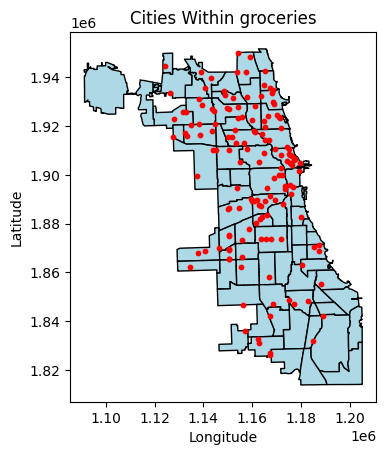

In [11]:
import matplotlib.pyplot as plt

# Plot districts
ax = chicago.plot(color='lightblue', edgecolor='black')

# Plot schools
groceries_with_community.plot(ax=ax, color='red', markersize=10)
plt.title("Cities Within groceries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Important Considerations
- Performance: Spatial joins can be computationally intensive, especially with large datasets. Consider indexing your geometries using spatial indexing techniques to speed up the join.

- Handling Overlaps: If geometries overlap but do not perfectly contain each other, consider what kind of join you need (e.g., "intersects" might be more appropriate in some cases than "within").

- Data Integrity: After performing a spatial join, validate the results to ensure that they meet your analytical requirements. For example, check for unexpected ```NaN``` values or ensure that the join worked as intended.

GeoPandas provides two spatial-join functions:

- ```GeoDataFrame.sjoin()```: joins based on binary predicates (intersects, contains, etc.)

- ```GeoDataFrame.sjoin_nearest()```: joins based on proximity, with the ability to set a maximum search radius

# Attribute Join vs. Spatial Join
- **Attribute join**: Based on common columns (like IDs or names), it combines attributes from two datasets.
- **Spatial join**: Combines datasets based on their geometries (e.g., finding which points fall within polygons). This is different from an attribute join because it uses spatial relationships rather than column values for the match.

# Binary predicate joins
A binary predicate join combines two DataFrames (or tables) based on a condition or predicate that relates their attributes, rather than their geometries. This is similar to traditional SQL joins.

Binary predicate joins are available via ```GeoDataFrame.sjoin()```.

```GeoDataFrame.sjoin()``` has two core arguments: ```how``` and ```predicate```.

**predicate**

The ```predicate``` argument specifies how GeoPandas decides whether or not to join the attributes of one object to another, based on their geometric relationship.

The values for ```predicate``` correspond to the names of geometric binary predicates and depend on the spatial index implementation.

The default spatial index in GeoPandas currently supports the following values for predicate which are defined in the Shapely documentation:

- intersects

- contains

- within

- touches

- crosses

- overlaps

**how**

The how argument specifies the type of join that will occur and which geometry is retained in the resultant GeoDataFrame. It accepts the following options:

- left: use the index from the first (or left_df)GeoDataFrame that you provide to ```GeoDataFrame.sjoin()```; retain only the left_df geometry column

- right: use index from second (or right_df); retain only the right_df geometry column

- inner: use intersection of index values from both GeoDataFrame; retain only the left_df geometry column

Note more complicated spatial relationships can be studied by combining geometric operations with spatial join. 
To find all polygons within a given distance of a point, for example, one can first use the ```buffer()``` method to expand each point into a circle of appropriate radius, then intersect those buffered circles with the polygons in question.



# Nearest joins
Proximity-based joins can be done via GeoDataFrame.sjoin_nearest().

GeoDataFrame.sjoin_nearest() shares the how argument with GeoDataFrame.sjoin(), and includes two additional arguments: max_distance and distance_col.

**max_distance**

The max_distance argument specifies a maximum search radius for matching geometries. This can have a considerable performance impact in some cases. If you can, it is highly recommended that you use this parameter.

**distance_col**

If set, the resultant GeoDataFrame will include a column with this name containing the computed distances between an input geometry and the nearest geometry.

## Let's play with some Australian's data

In the example Scenario about Australia below, we will be adding bushfire data to Spatial Boundaries

We'll have a GeoDataFrame of administrative boundaries (polygons) and a separate CSV file that contains bushfire recovery data by region. 
Both datasets will be manipulated to share a column indicating the region_id (LGA_CODE11). An attribute join can be used to add the population data to the corresponding regions.

The steps involved are:
- Load the shapefile with geometries and the CSV with population data.
- Merge the two datasets based on region_id.
- The result will be a GeoDataFrame where each polygon now also has a population value attached to it.


### Where to find the data?
Publicably available data can be found at https://data.gov.au/home

In [12]:
#==========================================================================
# Pre-sampling the data
#==========================================================================
# Specify the directory in which you want to save the figures
outputPath        = os.path.join(os.path.abspath("."),"/Users/Roberta/Documents/Geospatial_Analysis/notebooks/figures/")

# Base directory
main_directory    = ('/Users/Roberta/Documents/Geospatial_Analysis/notebooks/data/ASGC_LGA2011/')


# Get to the base directory
os.chdir(main_directory)
cur_dir           = os.getcwd()
print ('Current directory: ',cur_dir)
plt.figure().clf()

print ('-----------------------------')
print ('Start sampling the data:')

Current directory:  /Users/Roberta/Documents/Geospatial_Analysis/notebooks/data/ASGC_LGA2011
-----------------------------
Start sampling the data:


<Figure size 640x480 with 0 Axes>

In [13]:
#==========================================================================
# Load the dataset
#==========================================================================
lga_gdf = gpd.read_file('LGA11aAust.shp')    # Load the data using Geopandas
lga_gdf.head(2)

,STATE_CODE,LGA_CODE11,LGA_NAME11,geometry
0,1,10050,Albury (C),"POLYGON ((146.91383 -36.00692, 146.915 -36.004..."
1,1,10110,Armidale Dumaresq (A),"POLYGON ((151.53577 -30.45832, 151.53576 -30.4..."


In [14]:
# State indentifier index
lga_gdf.STATE_CODE.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [15]:
#==========================================================================
# Extract VIC local governament area
#==========================================================================
lga_gdf = lga_gdf[lga_gdf['STATE_CODE']=='2'] 
lga_gdf['LGA_CODE11'] = lga_gdf['LGA_CODE11'].astype(int)
lga_gdf.info

<bound method DataFrame.info of     STATE_CODE  LGA_CODE11          LGA_NAME11  \
153          2       20110          Alpine (S)   
154          2       20260         Ararat (RC)   
155          2       20570        Ballarat (C)   
156          2       20660         Banyule (C)   
157          2       20740      Bass Coast (S)   
..         ...         ...                 ...   
228          2       27260         Wyndham (C)   
229          2       27350           Yarra (C)   
230          2       27450    Yarra Ranges (S)   
231          2       27630    Yarriambiack (S)   
232          2       29399  Unincorporated Vic   

                                              geometry  
153  POLYGON ((146.67398 -37.11328, 146.67397 -37.1...  
154  POLYGON ((143.2696 -37.20763, 143.26966 -37.20...  
155  POLYGON ((143.6215 -37.46772, 143.61693 -37.46...  
156  POLYGON ((145.07453 -37.71613, 145.07461 -37.7...  
157  MULTIPOLYGON (((145.35086 -38.56586, 145.35083...  
..                       

In [16]:
#==========================================================================
# Loading the bushfire recovery (attribute) dataframe
#==========================================================================
df = pd.read_csv('/Users/Roberta/Documents/Geospatial_Analysis/notebooks/data/csvdata/black-summer-bushfire-recovery-data.csv',encoding='cp1252')
df.head(2)

,location_name,location_id,location_type,metric_id,category,metric_name,attribute,unit,value
0,Unincorporated ACT,89399,LGA,2_107,Bushfire Impact,Disaster Declarations,Disaster Recovery Payment Eligible,NaN,Not active
1,Armidale Regional (A),10130,LGA,2_107,Bushfire Impact,Disaster Declarations,Disaster Recovery Payment Eligible,NaN,Active


In [17]:
#==========================================================================
# Process data to create a common region_id for merging
#==========================================================================
# Extract the state code index
df['STATE_CODE'] = df['location_id'].astype(str).str[0]
# Extract Vic data
Vic_LGA_data =  df[df['STATE_CODE']=='2'] 

In [18]:
# The geodataframe has only 80 LGA compared to over 400 entries in the attribute dataframe below.
print("my dataframe legnth is :", Vic_LGA_data[Vic_LGA_data.columns[0]].count())
print("my geodataframe length is :", lga_gdf[lga_gdf.columns[0]].count())

my dataframe legnth is : 428
my geodataframe length is : 80


We will create an attribute column "'LGA_CODE11" in the Dataframe, Vic_LGA_data, which will be using to merge the bushfire data to the corresponding regions.

In [19]:
#==========================================================================
# Attribute Join
#==========================================================================
Vic_LGA_data['LGA_CODE11'] = Vic_LGA_data['location_id'] 
df_merge = pd.merge(lga_gdf,Vic_LGA_data, on = ['LGA_CODE11'], how='inner')
#df['location_id'] = df['location_id'].fillna(0).astype(int) # use something like this in case of NaN after merging

In [20]:
# Here I want to retrieve as much data as possible and be able to visualise it on a map;
print("my merged geodataframe length is :", df_merge[df_merge.columns[0]].count(), "some regions are affacted by more than one agent")

my merged geodataframe length is : 428 some regions are affacted by more than one agent


In [21]:
df_merge.head(2)

,STATE_CODE_x,LGA_CODE11,LGA_NAME11,geometry,location_name,location_id,location_type,metric_id,category,metric_name,attribute,unit,value,STATE_CODE_y
0,2,20110,Alpine (S),"POLYGON ((146.67398 -37.11328, 146.67397 -37.1...",Alpine (S),20110,LGA,2_107,Bushfire Impact,Disaster Declarations,Disaster Recovery Payment Eligible,NaN,Active,2
1,2,20110,Alpine (S),"POLYGON ((146.67398 -37.11328, 146.67397 -37.1...",Alpine (S),20110,LGA,2_108,Bushfire Impact,Disaster Declarations,Disaster Recovery Allowance Eligible,NaN,Active,2


In [22]:
# areas eligibility for repayment
df_merge['attribute'].value_counts()

attribute
Applications approved ($)                                   116
Applications approved (no.)                                  97
Projects                                                     20
Disaster Recovery Allowance Eligible                         19
Disaster Recovery Funding Arrangements (DRFA) Categories     19
Disaster Recovery Payment Eligible                           19
Bushland and forests affected                                19
Agricultural land affected                                   19
Total area affected                                          19
Support received                                             19
Projects (may not be specific to this LGA)                   13
Funding received                                             11
Value of projects                                            10
Number of projects                                           10
Regional Tourism Organisation (RTO)                           8
Funding received by the RTO   

Text(0.5, 1.0, 'Victorian LGAs eligible for Bushfire Recovery fundings')

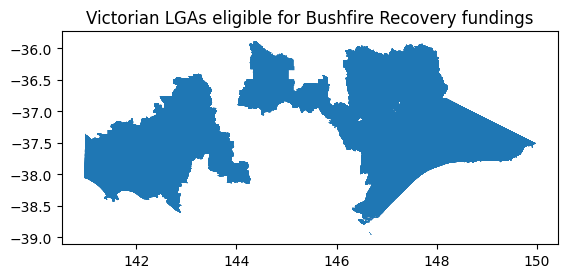

In [23]:
# This plotting tools shows the areas that have been seriously affected by the bushfires
df_merge.geometry.plot()
plt.title("Victorian LGAs eligible for Bushfire Recovery fundings")

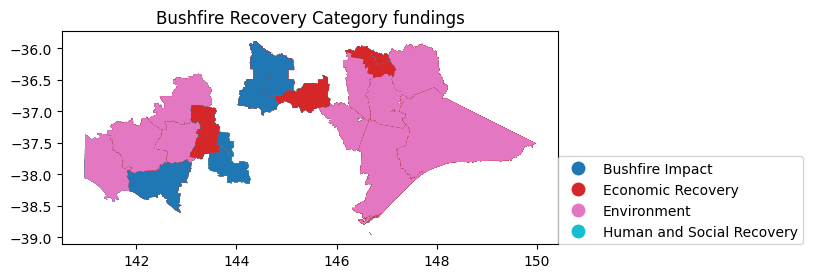

In [24]:
# Recovery impact
df_merge.plot(column="category",  missing_kwds={'color': 'lightgrey'},categorical=True, legend=True,legend_kwds={'loc': (1,0)})
plt.title("Bushfire Recovery Category fundings")
plt.savefig(outputPath +"inner_join.pdf")

my left merged geodataframe length is : 489 , here we can see all the Victorian LGAs


Text(0.5, 1.0, 'All Victorian LGAs')

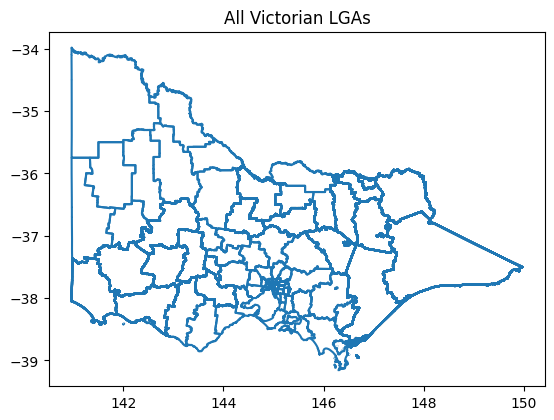

In [25]:
#==========================================================================
# Merging on the GeoPandas dataframe
#==========================================================================
df_merge_left = pd.merge(lga_gdf,Vic_LGA_data, on = ['LGA_CODE11'], how='left')
df_merge_left.boundary.plot()
print("my left merged geodataframe length is :", df_merge_left[df_merge_left.columns[0]].count(), ", here we can see all the Victorian LGAs")
plt.title("All Victorian LGAs")

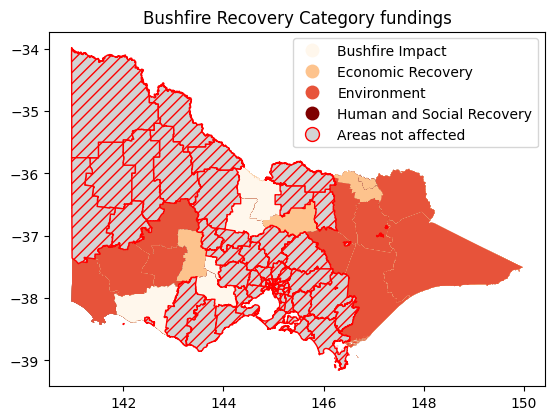

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

df_merge_left.plot(
    column="category",
    legend=True, 
    cmap='OrRd',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Areas not affected",    
    });
plt.title("Bushfire Recovery Category fundings")
plt.savefig(outputPath +"left_join")

# Interactive mapping

Alongside static plots, geopandas can create interactive maps based on the folium library (folium/leaflet.js).

Creating maps for interactive exploration mirrors the API of static plots in an explore() method of a GeoSeries or GeoDataFrame.

```GeoDataFrame.explore(*args, **kwargs)[source]```


![alt](img/ExploreGeoPandas.jpg)

In [ ]:
df_merge.explore("attribute")